In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchvision
from time import localtime, strftime
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import math
import torch_optimizer 

In [2]:
plt.rcParams["figure.figsize"] = (20,20)

In [3]:
# Pretrainbed feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, pretmodel):
        super(FeatureExtractor, self).__init__()
        self.model = pretmodel
        self.model = nn.Sequential(*list(self.model.children())[:-1]) 

    def forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        return features.view(features.size(0), -1) 

# Simple Fully Connected Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1152)
        self.bn1 = nn.BatchNorm1d(1152)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1152, 768)
        self.bn2 = nn.BatchNorm1d(768)
        self.fc3 = nn.Linear(768, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x) 
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x) 
        return x
        
# Custom Dataset
class RealFakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Load Image Paths and Labels
def load_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []
    
    for model in os.listdir(root_dir):
        model_path = os.path.join(root_dir, model)
        if os.path.isdir(model_path):
            for label in ['0_real', '1_fake']:
                label_path = os.path.join(model_path, label)
                if os.path.isdir(label_path):
                    for img_name in os.listdir(label_path):
                        img_path = os.path.join(label_path, img_name)
                        image_paths.append(img_path)
                        labels.append(0 if '0_real' in label else 1)
                else:
                    for obj in os.listdir(model_path):
                        obj_path = os.path.join(model_path, obj)
                        label_path = os.path.join(obj_path, label)
                        if os.path.isdir(label_path):
                            for img_name in os.listdir(label_path):
                                img_path = os.path.join(label_path, img_name)
                                image_paths.append(img_path)
                                labels.append(0 if '0_real' in label else 1)
    
    return image_paths, labels

In [5]:
# Train Classifier Network
def train_classifier(classifier, feature_extractor, dataloader, device, num_epochs=10, clip_value=1.0, lrate = 0.25):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch_optimizer.AccSGD(
        classifier.parameters(),
        lr=lrate,
        kappa=1000.0,
        xi=10.0,
        small_const=0.7,
        weight_decay=0
    )
    
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.25)
    # scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=4)  # Adjusted parameters
    feature_extractor.to(device)
    classifier.to(device)
    classifier.train()
    feature_extractor.eval()
    # loss_list = []
    running_loss_list = []
    mult = 0.8
    
    for epoch in range(num_epochs):
        if(epoch % 10 == 0):
            optimizer.param_groups[0]['lr'] = lrate
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f'Teacher training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            
            optimizer.zero_grad()
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), clip_value)
            optimizer.step()
            
            running_loss += loss.item()
            # loss_list.append(loss.item())
        # scheduler.step()
        running_loss_list.append(running_loss/len(dataloader))
        print(f'Epoch {epoch}, Loss: {running_loss/len(dataloader)}')
        print(optimizer.param_groups[0]['lr'])
        l = len(running_loss_list)
        if((running_loss_list[l-2]-running_loss_list[l-1])/running_loss_list[l-2]<0.02):
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']*mult
            print(optimizer.param_groups[0]['lr'])
        
        save_checkpoint(classifier, filename='classifier_cpt', epoch=epoch)
        add_log(f'Saved classifier_cpt at epoch {epoch}. \nLoss: {running_loss/len(dataloader)}')
    print('Finished Training Teacher')
    return running_loss_list

In [6]:
# Get model accuracy, precision, recall, f1
def test_classifierr(classifier, feature_extractor, dataloader, device):
    classifier.to(device) 
    feature_extractor.to(device) 
    classifier.eval()
    feature_extractor.eval()

    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            features = feature_extractor(images)
            
            outputs = classifier(features)
            
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f'Test accuracy: {accuracy * 100:.2f}%')
    print(f'Test precision: {precision * 100:.2f}%')
    print(f'Test recall: {recall * 100:.2f}%')
    print(f'Test f1: {f1 * 100:.2f}%')
    return accuracy, precision, recall, f1

In [7]:
def draw_auc_roc_curve(classifier, feature_extractor, dataloader, device):
    classifier.to(device) 
    feature_extractor.to(device) 
    # Lists to store true labels and predicted probabilities
    true_labels = []
    predicted_probs = []
    
    # Iterate over test dataset to obtain true labels and predicted probabilities
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = classifier(feature_extractor(inputs))
            predicted_probs.extend(outputs[:, 1].cpu().numpy())  # Assuming positive class probabilities are in the second column
            true_labels.extend(labels.cpu().numpy())
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    
    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
# Define Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

In [9]:
# Draw array graph
def draw_graph(loss_data, ylim):
    plt.grid(True)
    plt.ylim((0, ylim))
    plt.plot(loss_data, marker="o", markersize=2)
    plt.show()

# Draw multiple array graphs
def draw_graphs(loss_data, ylim):
    plt.grid(True)
    plt.ylim((0, ylim))
    for i in loss_data:
        plt.plot(i, marker="o", markersize=2)
    plt.show()

# Get differences list
def get_deltas(loss_data):
    out = []
    for i in range(len(loss_data)-1):
        out.append(math.fabs(loss_data[i] - loss_data[i+1]))
    return out

In [10]:
# Save and Load Checkpoints
def save_checkpoint(model, filename='checkpoint', epoch=0):
    modelfilename = filename + f'_epoch{epoch}.pth.tar'
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), f'models/{modelfilename}')
    print(f'Saved checkpoint as: {modelfilename}')
def load_checkpoint(model, path):
    model.load_state_dict(torch.load(path))
    print(f'Loaded model: {path}')

# Logging Function
def add_log(msg):
    with open('log.txt', 'a') as file:
        time = strftime("%H:%M", localtime())
        file.write(time + ': ' + msg + '\n')

# Initialize Weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.constant_(m.bias, 0)

# Save and load loss data
def save_loss(filename, loss_data):
    with open(filename, 'a') as file:
        file.write(str(loss_data) + '\n')
def load_loss(filename):
    with open(filename) as file:
        f = file.read()[1:-2]
        l = list(map(float, f.split(', ')))
        return l

# Draw array grapgh from files
def draw_array_graph_from_folder(directory):
    plt.grid(True)
    plt.ylim((0,2))
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            l = load_loss(f)
            plt.plot(l, marker="o", markersize=1)
    plt.show() 

In [12]:
# Load image paths and labels
image_paths, labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/generated_images_classifier/image_classification/content/CNN_synth/train_set/')

# Create a dataset instance 
full_dataset  = RealFakeDataset(image_paths, labels, transform=transform)
# exessive_dataset = RealFakeDataset(image_paths, labels, transform=transform)
# half1 = int(0.01 * len(exessive_dataset))
# half2 = len(exessive_dataset) - half1
# full_dataset, _ = torch.utils.data.random_split(exessive_dataset, [half1, half2])
# Define the split ratio
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
len(train_dataset)

103358

In [14]:
# Initialize networks
feature_extractor = FeatureExtractor(models.efficientnet_b3(pretrained=True))
feature_dim = 1536  # efficientnet_b0 output feature dimension
classifier = SimpleNN(feature_dim, 2)
classifier.apply(init_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
classifier.to(device)
feature_extractor.to(device)

FeatureExtractor(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [16]:
def reset_classifier_extractor(pretrained):
    feature_extractor = FeatureExtractor(pretrained)
    feature_dim = 1536 
    classifier = SimpleNN(feature_dim, 2)
    classifier.apply(init_weights)
    return feature_extractor, classifier

def test_train_classifier(classifier, feature_extractor, train_loader, device, optimizer, epoch, filename):
    feature_extractor, classifier = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
    rl = train_classifier(classifier, feature_extractor, train_loader, device, optimizer, epoch, lrate= 0.2)
    save_loss(f'r{filename}.txt',rl)
    return rl

In [ ]:
# Train classifier
loss = train_classifier(classifier, feature_extractor, train_loader, device, 60)

In [62]:
testacc = test_classifierr(model, feature_extractor, test_loader, device)
add_log(f'Test dataset metrics: {testacc}')

Test accuracy: 95.02%
Test precision: 94.86%
Test recall: 95.29%
Test f1: 95.07%


In [61]:
draw_loss_graph(loss)

NameError: name 'loss' is not defined

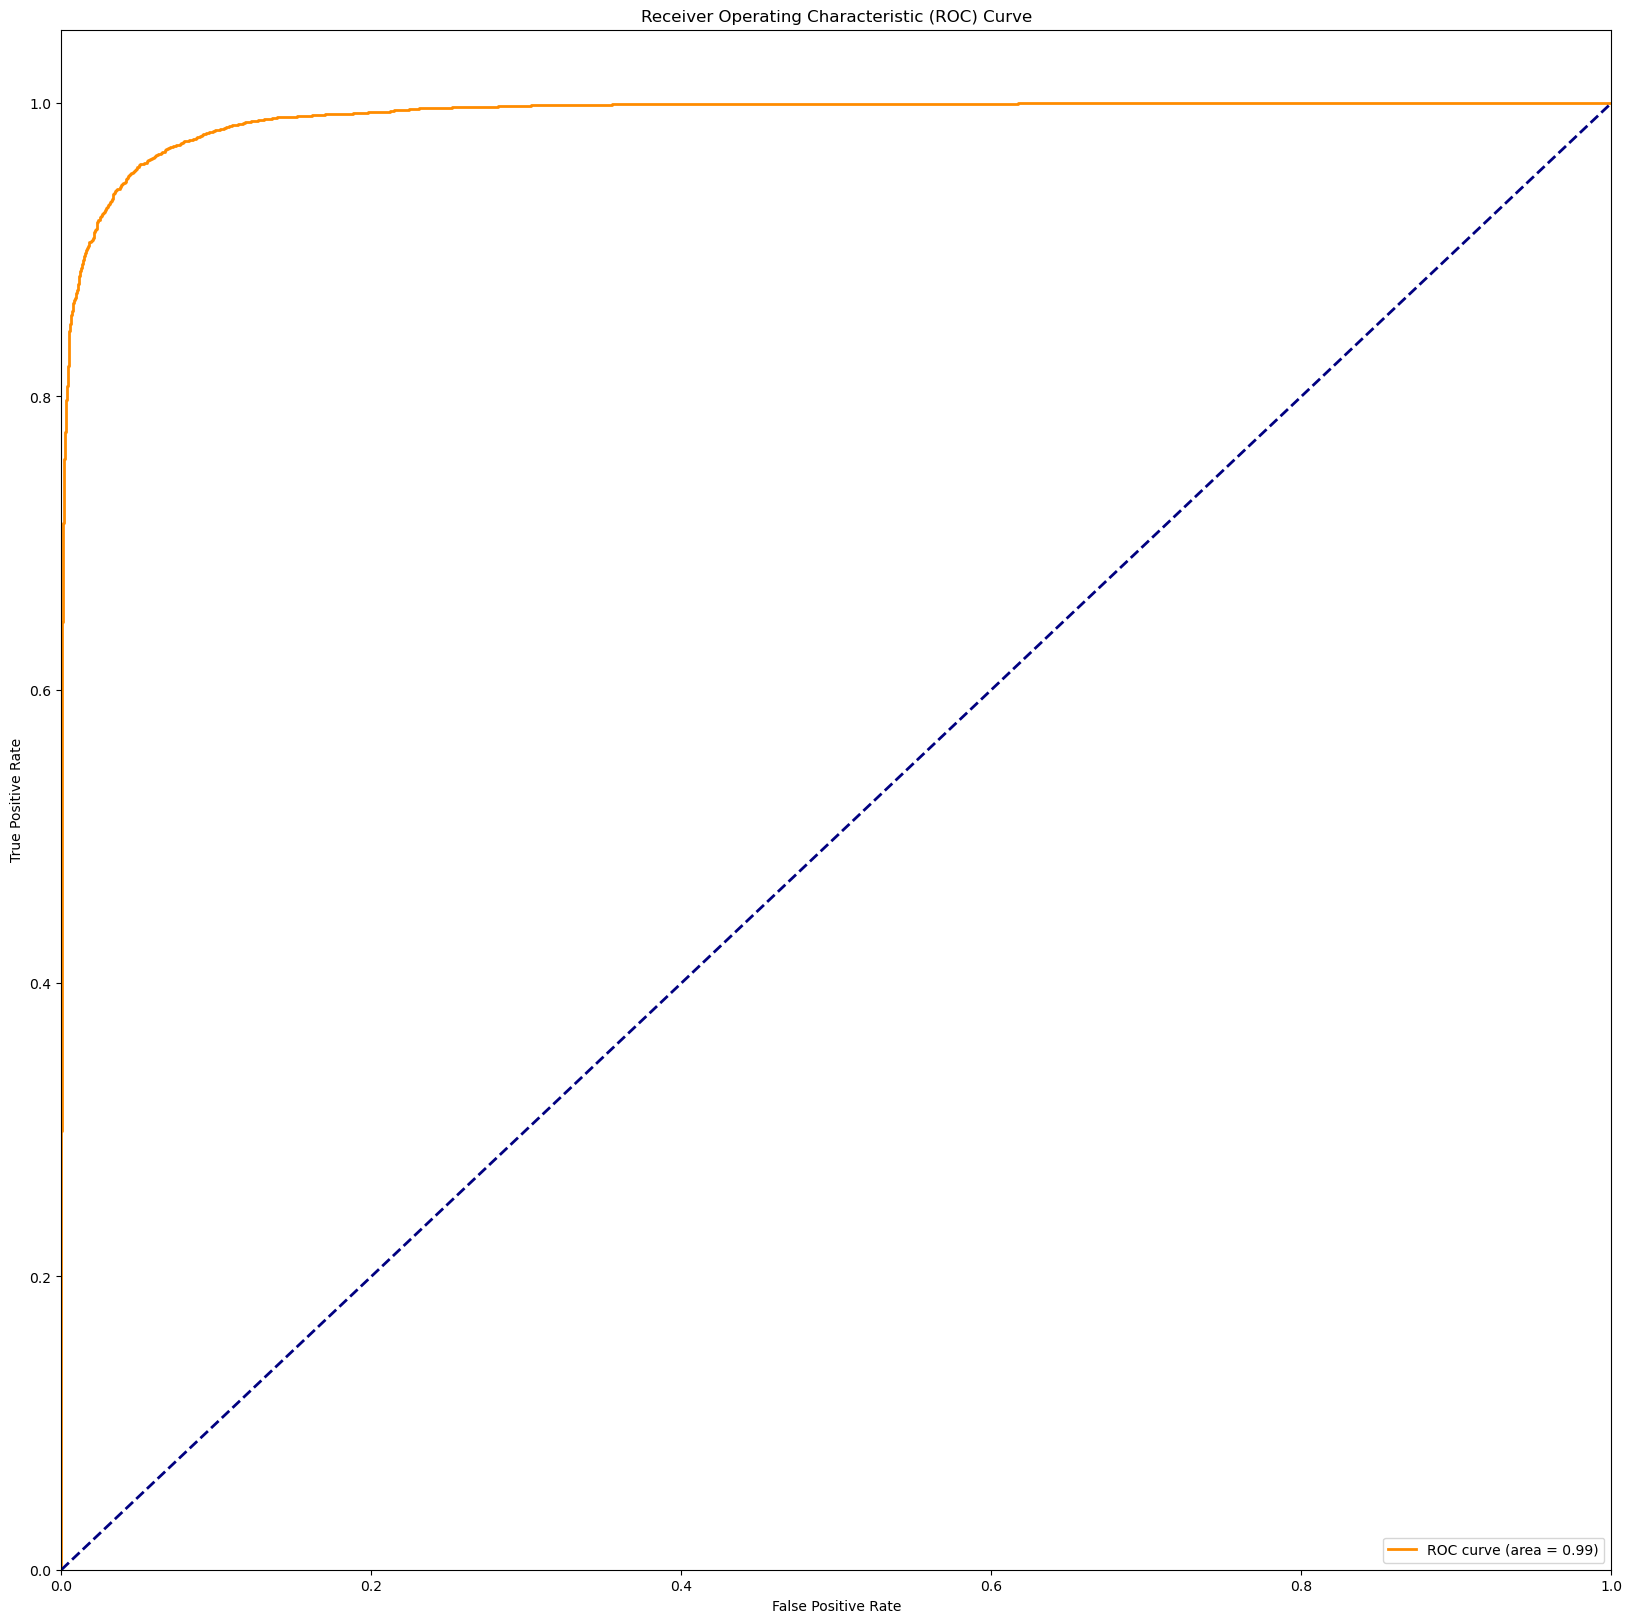

In [59]:
draw_auc_roc_curve(model, feature_extractor, test_loader, device)

In [ ]:
save_loss('loss.txt', loss)

In [22]:
mytest_image_paths, mytest_labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/generated_images_classifier/image_classification/content/mytestset/')
mytest_dataset = RealFakeDataset(mytest_image_paths, mytest_labels, transform=transform)
mytest_loader = DataLoader(mytest_dataset, batch_size=64, shuffle=True)

In [45]:
mytestacc = test_classifierr(classifier, feature_extractor, mytest_loader, device)
add_log(f'My test dataset accuracy: {mytestacc}')

Test Accuracy: 57.97%


In [46]:
comb_test_image_paths, comb_test_labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/vsu_common_rep/2year/2term/project/image_classification/content/combined/')
comb_test_dataset = RealFakeDataset(comb_test_image_paths, comb_test_labels, transform=transform)
comb_test_loader = DataLoader(comb_test_dataset, batch_size=64, shuffle=False)

In [47]:
combtestacc = test_classifierr(classifier, feature_extractor, comb_test_loader, device)
add_log(f'Combined test dataset accuracy: {combtestacc}')

Test Accuracy: 70.11%


In [48]:
comb2_test_image_paths, comb2_test_labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/vsu_common_rep/2year/2term/project/image_classification/content/combined2/')
comb2_test_dataset = RealFakeDataset(comb2_test_image_paths, comb_test_labels, transform=transform)
comb2_test_loader = DataLoader(comb2_test_dataset, batch_size=64, shuffle=False)

In [49]:
comb2testacc = test_classifierr(classifier, feature_extractor, comb2_test_loader, device)
add_log(f'Combined test dataset accuracy: {combtestacc}')

Test Accuracy: 48.56%


In [17]:
limage_paths, ltest_labels = load_image_paths_and_labels("D:progan_train/progan_train/")
lfull_dataset = RealFakeDataset(limage_paths, ltest_labels, transform=transform)
ltrain_size = int(0.99 * len(lfull_dataset))
ltest_size = len(lfull_dataset) - ltrain_size
ltrain_dataset, ltest_dataset = torch.utils.data.random_split(lfull_dataset, [ltrain_size, ltest_size])
ltest_loader = DataLoader(ltest_dataset, batch_size=64, shuffle=True)

In [51]:
ltestacc = test_classifierr(classifier, feature_extractor, ltest_loader, device)
add_log(f'Large test dataset accuracy: {ltestacc}')

Test Accuracy: 67.50%


In [19]:
acclist = []
model = SimpleNN(feature_dim, 2)

In [ ]:
path = "models_teacher/"
for filename in os.listdir(path):
    load_checkpoint(model, os.path.join(path, filename))
    acc = test_classifierr(model, feature_extractor, ltest_loader, device)
    acclist.append(acc)

Loaded model: models_teacher/teacher_cpt_epoch10.pth.tar
Test accuracy: 67.71%
Test precision: 72.90%
Test recall: 56.77%
Test f1: 63.83%
Loaded model: models_teacher/teacher_cpt_epoch11.pth.tar
Test accuracy: 66.17%
Test precision: 75.30%
Test recall: 48.51%
Test f1: 59.01%
Loaded model: models_teacher/teacher_cpt_epoch12.pth.tar
Test accuracy: 68.02%
Test precision: 69.52%
Test recall: 64.59%
Test f1: 66.96%
Loaded model: models_teacher/teacher_cpt_epoch13.pth.tar
Test accuracy: 67.28%
Test precision: 76.58%
Test recall: 50.14%
Test f1: 60.60%
Loaded model: models_teacher/teacher_cpt_epoch14.pth.tar
Test accuracy: 68.83%
Test precision: 65.65%
Test recall: 79.48%
Test f1: 71.91%
Loaded model: models_teacher/teacher_cpt_epoch15.pth.tar
Test accuracy: 68.85%
Test precision: 70.38%
Test recall: 65.50%
Test f1: 67.85%
Loaded model: models_teacher/teacher_cpt_epoch16.pth.tar
Test accuracy: 67.84%
Test precision: 70.02%
Test recall: 62.79%
Test f1: 66.21%
Loaded model: models_teacher/teach

In [19]:
path = "models"
for filename in os.listdir(path):
    load_checkpoint(model, os.path.join(path, filename))
    acc = test_classifierr(model, feature_extractor, ltest_loader, device)
    acclist.append(acc)

Loaded model: models\classifier_cpt_epoch30.pth.tar
Test accuracy: 67.71%
Test precision: 70.95%
Test recall: 60.39%
Test f1: 65.24%
Loaded model: models\classifier_cpt_epoch31.pth.tar
Test accuracy: 69.01%
Test precision: 71.27%
Test recall: 64.09%
Test f1: 67.49%
Loaded model: models\classifier_cpt_epoch32.pth.tar
Test accuracy: 68.67%
Test precision: 70.71%
Test recall: 64.14%
Test f1: 67.27%
Loaded model: models\classifier_cpt_epoch33.pth.tar
Test accuracy: 68.83%
Test precision: 72.84%
Test recall: 60.44%
Test f1: 66.06%
Loaded model: models\classifier_cpt_epoch34.pth.tar
Test accuracy: 68.58%
Test precision: 72.72%
Test recall: 59.86%
Test f1: 65.67%
Loaded model: models\classifier_cpt_epoch35.pth.tar
Test accuracy: 67.82%
Test precision: 72.13%
Test recall: 58.48%
Test f1: 64.59%
Loaded model: models\classifier_cpt_epoch36.pth.tar
Test accuracy: 69.62%
Test precision: 70.08%
Test recall: 68.90%
Test f1: 69.48%
Loaded model: models\classifier_cpt_epoch37.pth.tar
Test accuracy: 68

In [41]:
accuracy_compare = [item[0] for item in acclist]
precision_compare = [item[1] for item in acclist]
recall_compare = [item[2] for item in acclist]
f1_compare = [item[3] for item in acclist]

In [46]:
avarage = [(accuracy_compare[i]*4+precision_compare[i]+recall_compare[i]+f1_compare[i])/7 for i in range(54)]

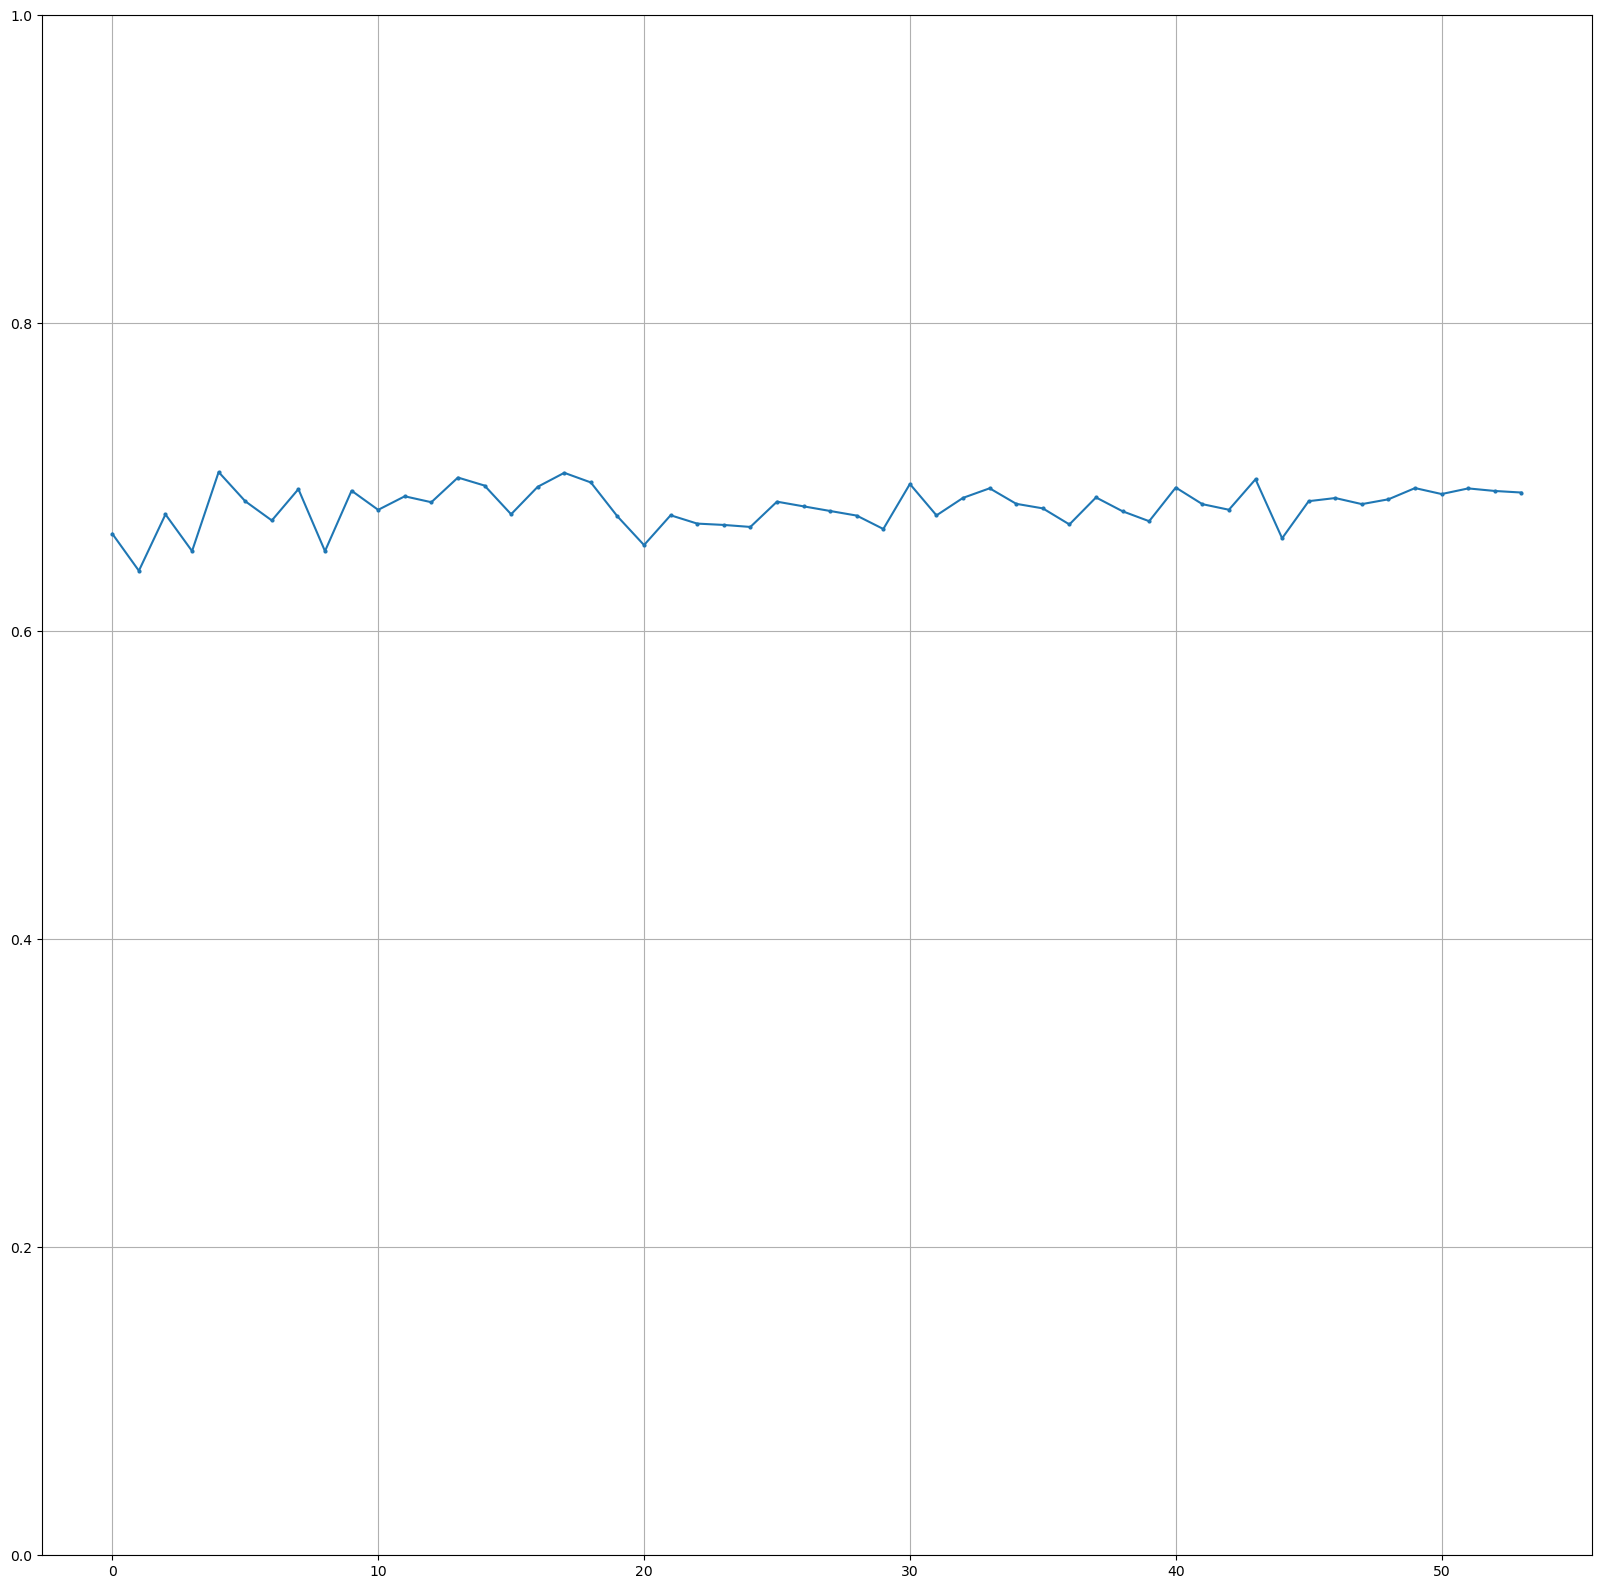

In [47]:
draw_loss_graph(avarage, 1)

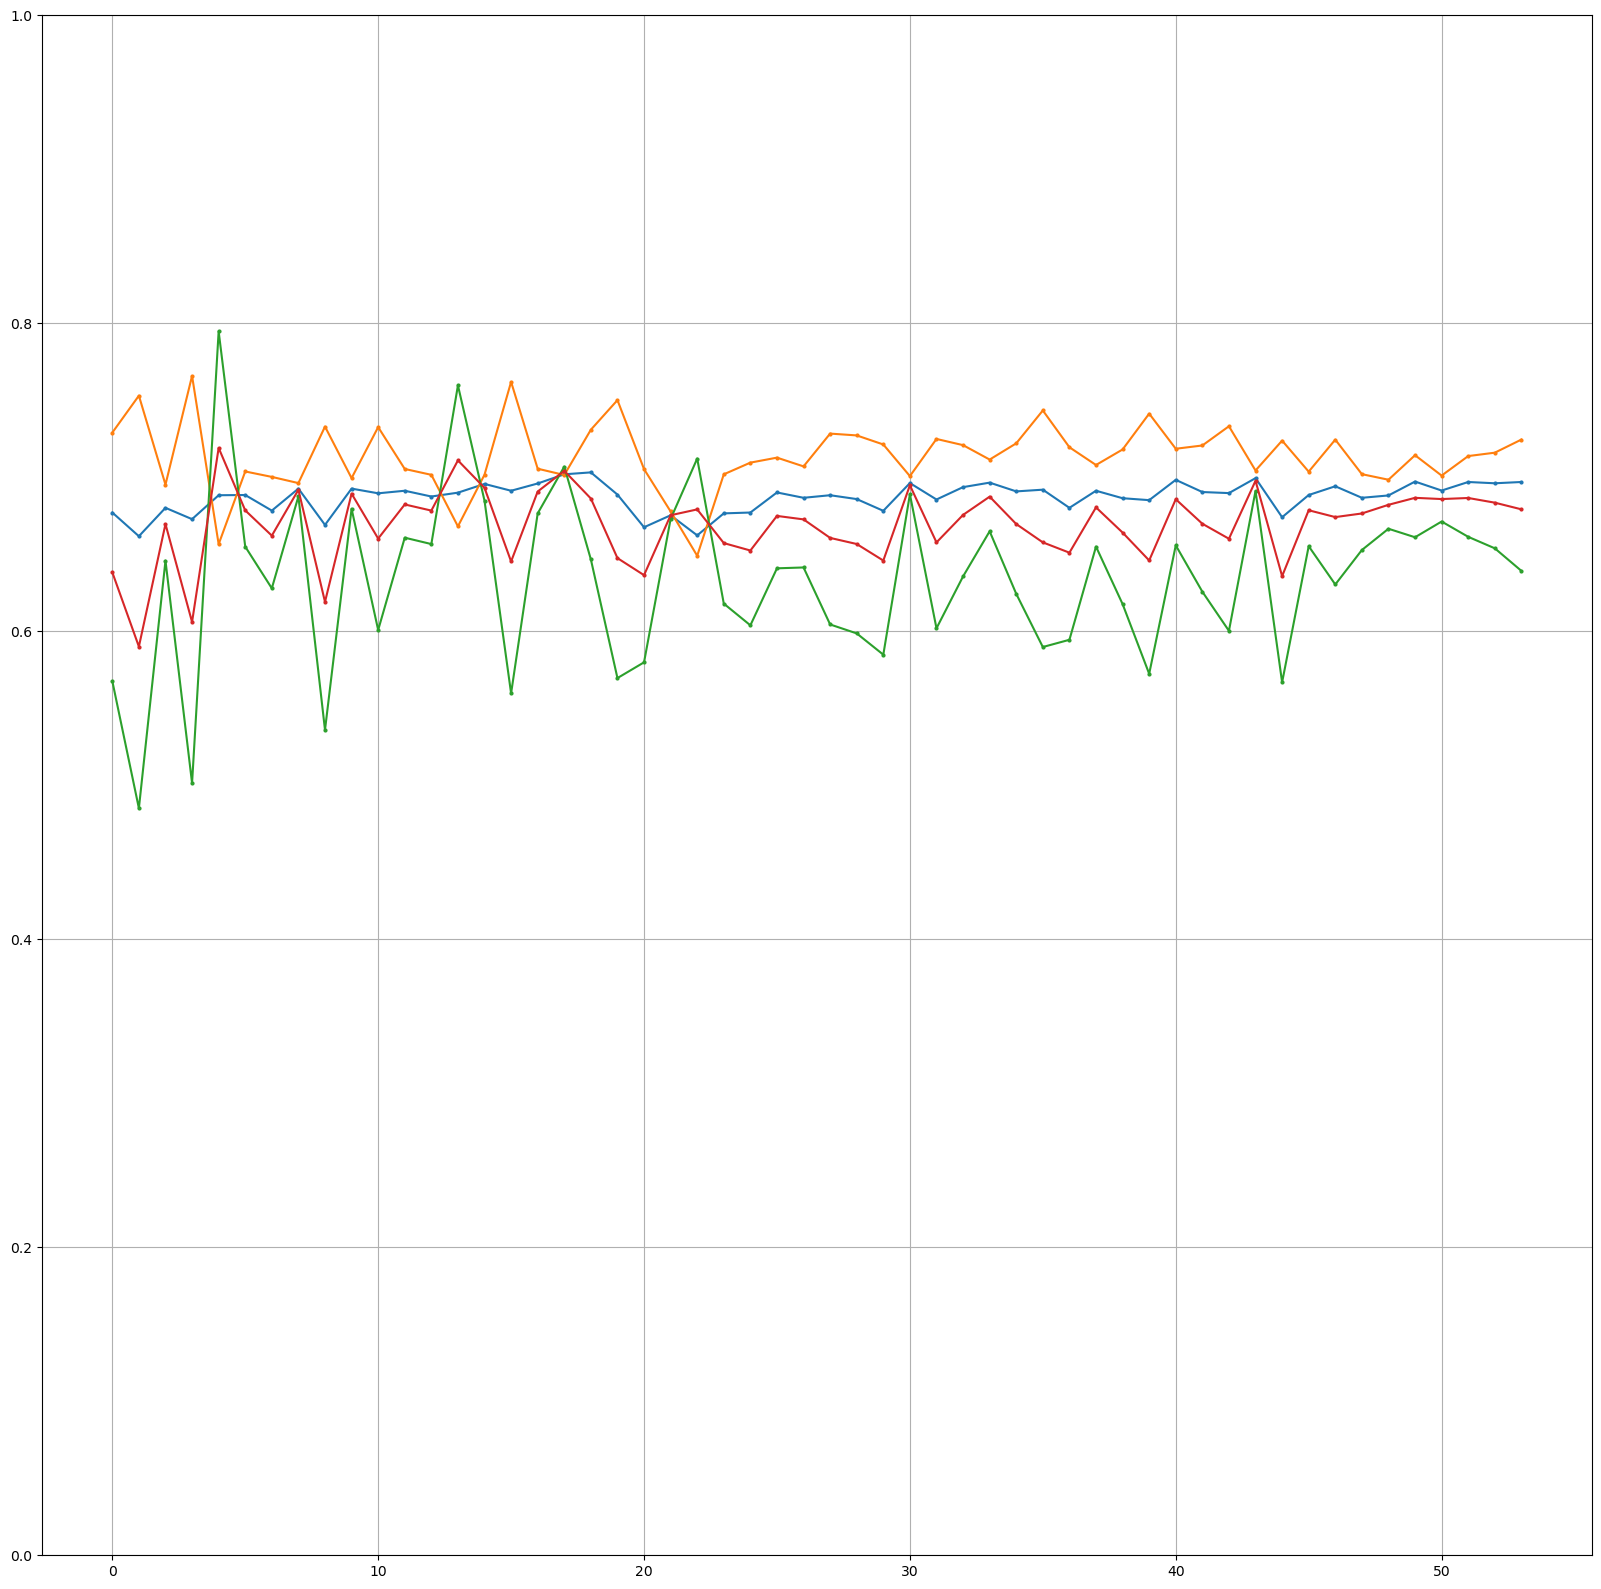

In [43]:
draw_loss_graphs([accuracy_compare, precision_compare, recall_compare, f1_compare], 1)

In [20]:
load_checkpoint(model, 'models/classifier_final.pth.tar')

Loaded model: models/classifier_cpt_epoch49.pth.tar


In [92]:
test_classifierr(model, feature_extractor, ltest_loader, device)

Test accuracy: 70.00%
Test precision: 71.63%
Test recall: 65.51%
Test f1: 68.44%


(0.699986136143075, 0.7163358778625954, 0.6551242669645351, 0.6843640606767795)

In [93]:
test_classifierr(model, feature_extractor, test_loader, device)

Test accuracy: 89.40%
Test precision: 89.43%
Test recall: 89.82%
Test f1: 89.62%


(0.8940356987374837,
 0.8943338437978561,
 0.8981544771018455,
 0.8962400886691106)

In [23]:
test_classifierr(model, feature_extractor, mytest_loader, device)

Test accuracy: 57.90%
Test precision: 62.17%
Test recall: 40.37%
Test f1: 48.95%


(0.5790229885057471,
 0.6216814159292036,
 0.40373563218390807,
 0.48954703832752616)

Loaded model: models\classifier_cpt_epoch49.pth.tar

Test accuracy: 69.94%

Test precision: 70.44%

Test recall: 69.12%

Test f1: 69.77%